# 문서 분류란?
문서 분류(document classification), 혹은 문서 범주화(document categorization)란 주어진 문서에 대하여 미리 정해진 하나 혹은 복수의 부류(class, label)을 부여하는 절차를 말한다. 분류의 가장 간단한 경우는 주어진 문서들 가운데 단일한 부류에 속하는 문서들을 골라내는 경우로 이를 단일 부류 분류(one-class classification), 혹은 단항 분류(unary classificaion)이라고 부른다. 목표 부류가 참 또는 거짓, 0 또는 1 등 두 개의 값을 가지는 경우는 이진 분류(binary classification) 혹은 이진 부류 분류(binary class classification)라 부르며, 목표 분류가 신문의 면종, 책의 주제 분류와 같이 여러 값을 가지는 경우는 다항 분류(n-ary classification) 혹은 다중 부류 분류(multiclass classification)라고 부른다.

문서 분류가 응용된 가장 대표적인 예는 스팸 메일 분류기이다. 또한 최근 유행하기 시작한 전자우편 자동 분류 역시 문서 분류 기술이 적용된 것이다. 그 외에도 다국어 문서 집합에서 언어의 자동 감지, 텍스트 장르의 자동 판별, 문서의 난이도 측정, 작문의 자동 평가, 온라인 질의 자동 분류 등의 분야에서도 문서 문류 기술이 활용된다. 추후에 다룰 감성 분석도 문서 분류 과제에 속한다.

기계 학습의 관점에서 볼 때에 문서 분류는 지도 학습(supervised learning)이다. 학습 자료가 주어진 상태에서 모델을 학습하기 때문이다. 이는 지난 번 강의에서 다룬 문서 군집(document clustering)과 대비되는 것이다.

>넓은 의미의 문서 분류는 좁은 의미의 문서 분류와 문서 군집을 아울러 이르기도 한다.

문서 분류에서는 학습 자료와 시험 자료의 구축 방법, 학습 자료의 크기와 학습 시간, 분류기의 정확도의 상관 관계, 학습된 분류 모델의 평가 방법 등 전형적인 지도 학습에 의한 기계 학습의 관점에서 다루어야 할 문제들에 대처해야 한다.

# 문서 분류 실험
이제 scikit-learn 모듈을 이용하여 문서 분류를 실험해 보자.

## 실험용 문서 집합
실험용 문서 집합으로는 역대 대통령 연설문 자료 가운데 노무현 전 대통령의 연설문 780 건을 사용한다.
앞서 설명한 대로 문서 분류를 위해서는 미리 정의된 부류, 혹은 레이블이 필요한데 우리는 원자료에 부여된 연설 분야 분류를 레이블로 사용하기로 하자.
780 건의 실험용 문서들에서 연설 분야의 분포를 보면 다음과 같다.

| 분야           | 건수 |
| :------------: | :--: |
| 교육           |  24 |
| 국방           |  50 |
| 기타           |  30 |
| 환경           |   3 |
| 산업/경제      | 114 |
| 외교/통상      | 203 |
| 정치/사회      | 110 |
| 문화/체육/관광 | 124 |
| 국정전반       |  95 |
| 과학기술/정보  |  27 |

표에서 보듯이 이 실험 문서 집합은 레이블 분포가 심하게 치우쳐 있다. 특히 환경 분야의 연설은 건수가 매우 적다. 안정적인 실험을 위해 건수가 특히 적은 환경 분야의 연설문은 실험에서 제외하기로 하자. 결국 남은 연설문은 778건이며 9개의 부류로 구성된다.

## 나이브 베이즈 모델 문서 분류기 
문서 분류 과제에서 제법 좋은 성능을 보이는 것으로 알려진 나이브 베이즈(Naive Bayes) 모델을 이용한 문서 분류기를 구현해 보자.

In [5]:
import ujson
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

FEATURE_POSES = ["NC", "NQ"]
MA_KEY = "body_ma"
LABEL_KEY = "field"
EXCL_LABEL = "환경"


def read_documents_with_labels(input_file_name):
    documents = []
    labels = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)
            label = json_obj[LABEL_KEY]
            
            if label == EXCL_LABEL:
                continue
                
            labels.append(label)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue

                    morphs.append(morph_lex)

            document = " ".join(morphs)
            documents.append(document)

    # scikit의 다양한 기능을 이용하기 위해서
    # 파이썬 리스트를 numpy 모듈의 배열(array)로 바꾼다.
    documents = np.asarray(documents)
    labels = np.asarray(labels)
    
    return documents, labels


def build_doc_term_mats(train_documents, test_documents):
    vectorizer = CountVectorizer(tokenizer=str.split, binary=True)
    train_doc_term_mat = vectorizer.fit_transform(train_documents)
    test_doc_term_mat = vectorizer.transform(test_documents)

    return train_doc_term_mat, test_doc_term_mat


def build_classifier(train_doc_term_mat, train_labels):
    clf = MultinomialNB()
    clf.fit(train_doc_term_mat, train_labels)

    return clf


def test_classifier(clf, test_doc_term_mat, test_labels):
    pred_labels = clf.predict(test_doc_term_mat)
    accuracy = accuracy_score(test_labels, pred_labels)

    return accuracy


def main():
    input_file_name = "../data/speeches/nmh_speeches.ma.txt"
    documents, labels = read_documents_with_labels(input_file_name)
    train_documents, test_documents, train_labels, test_labels = \
            train_test_split(documents, labels)
    train_doc_term_mat, test_doc_term_mat = \
            build_doc_term_mats(train_documents, test_documents)
    clf = build_classifier(train_doc_term_mat, train_labels)
    accuracy = test_classifier(clf, test_doc_term_mat, test_labels)
    print("Accuracy: {}".format(accuracy))


# 실행
main()

Accuracy: 0.6102564102564103


위의 코드는 많은 부분이 지난 강의에서 살펴본 코드와 많은 부분이 겹친다. 부분 부분 살펴보자.

`read_documents_with_labels()` 함수는 지난 강의에서 구현한 `read_documents()` 함수와 거의 같다. 차이점은 다음과 같다.

* 분류 과제에서는 레이블이 필요하기 때문에 문서들과 함께 레이블들도 읽어서 돌려준다. 이 때 레이블을 검사하여 '환경' 분야 연설문은 제외한다.
* scikit-learn 모듈의 다양한 기능을 사용하기 위해 문서와 레이블의 리스트를 파이썬 리스트가 아닌 numpy 모듈의 배열(array)로 `asarray()` 함수를 이용하여 바꾼다.

`build_doc_term_mats()` 함수 또한 지난 시간에 살펴본 `build_doc_term_mat()` 함수와 닮았다. 다음은 분류 과제를 위해 추가된 부분이다.

* 분류 과제는 지도 학습에 속하므로 학습 자료와 실험 자료를 분리하여 사용해야 한다. 그러므로 두 개의 문서-어휘 행렬을 만들어야 한다. 
* 학습 문서 집합에 대해서는 `fit_transform()` 메소드를 실험 문서 집합에 대해서는 `transform()` 메소드를 사용한다.
* 벡터라이저는 `CountVectorizer`를 사용한다. `binary=True`를 지정하여 용어 빈도를 0, 1로만 나타내며, `tokenizer=str.spilt`을 지정하여 문자열의 `split()` 메소드를 이용하도록 설정한다.

`build_classifier()` 함수는 나이브 베이즈 모델을 이용한 문서 분류기를 생성하여 돌려준다. 이 과정에서 학습 자료를 이용한 학습이 이루어진다. 모델을 초기화할 때 몇 가지 인자를 지정할 수 있지만 여기서는 기본값을 사용한다.

`test_classifier()` 함수는 생성된 분류기를 실험 자료에 적용하여 예측 레이블을 얻고 이를 실제 레이블과 비교하여 정확도를 측정하여 돌려준다. 정확도 측정에는 `accuracy_score()` 함수를 이용한다.

`main()` 함수에서는 위에서 작성된 함수들을 조합하여 문서 분류를 수행한다. 이 때 학습 자료와 실험 자료를 나누기 위해 `train_test_split()` 함수를 사용한다. 이 함수에는 인자로 학습 자료와 실험 자료의 크기를 지정할 수 있는데 기본값은 전체 자료의 25%를 실험 자료로 사용하는 것이다.

## 교차 검증
위에서 살펴본 바와 같이 일반적으로 학습과 실험을 위한 문서 집합은 레이블의 쏠림 현상이 있을 때가 많으며, 경우에 따라서는 부정확한 레이블이 부여된 문서가 포함되어 있을 수도 있다.
문서 집합의 크기가 크면 일반적으로 이와 같은 현상이 별다른 문제를 일으키지 않겠지만 문서 집합의 크기가 작으면 분류기가 치우치게 생성될 가능성이 크다.
그럴 때에는 학습 자료와 실험 자료를 여러 번 서로 다르게 생성하여 분류기를 생성하여 성능 측정을 하는 것이 좋다.
이와 같은 방법을 교차 검증(cross validation)이라고 하며, 자료를 몇 개의 조각으로 나누어 사용하느냐에 따라 5절(five-fold) 교차 분석, 10절(ten-fold) 교차 분석 등으로 부른다.

In [6]:
import ujson
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
import numpy as np


FEATURE_POSES = ["NC", "NQ"]
MA_KEY = "body_ma"
LABEL_KEY = "field"
EXCL_LABEL = "환경"
NUM_FOLDS = 10


def read_documents_with_labels(input_file_name):
    documents = []
    labels = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)
            label = json_obj[LABEL_KEY]
            
            if label == EXCL_LABEL:
                continue
                
            labels.append(label)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue

                    morphs.append(morph_lex)

            document = " ".join(morphs)
            documents.append(document)

    # scikit의 다양한 기능을 이용하기 위해서
    # 파이썬 리스트를 numpy 모듈의 배열(array)로 바꾼다.
    documents = np.asarray(documents)
    labels = np.asarray(labels)
    
    return documents, labels


def build_doc_term_mats(train_documents, test_documents):
    vectorizer = CountVectorizer(tokenizer=str.split, binary=True)
    train_doc_term_mat = vectorizer.fit_transform(train_documents)
    test_doc_term_mat = vectorizer.transform(test_documents)

    return train_doc_term_mat, test_doc_term_mat


def build_classifier(train_doc_term_mat, train_labels):
    clf = MultinomialNB()
    clf.fit(train_doc_term_mat, train_labels)

    return clf


def test_classifier(clf, test_doc_term_mat, test_labels):
    pred_labels = clf.predict(test_doc_term_mat)
    accuracy = accuracy_score(test_labels, pred_labels)

    return accuracy


def main():
    input_file_name = "../data/speeches/nmh_speeches.ma.txt"
    documents, labels = read_documents_with_labels(input_file_name)
    cross_val_set = KFold(n=len(documents), n_folds=NUM_FOLDS, shuffle=True)
    accuracies = []

    for train, test in cross_val_set:
        train_documents = documents[train]
        train_labels = labels[train]
        test_documents = documents[test]
        test_labels = labels[test]

        train_doc_term_mat, test_doc_term_mat = \
                build_doc_term_mats(train_documents, test_documents)
        clf = build_classifier(train_doc_term_mat, train_labels)
        accuracy = test_classifier(clf, test_doc_term_mat, test_labels)
        accuracies.append(accuracy)

    print("Avg Accuracy: {}, Std Dev: {}".format(np.mean(accuracies), 
                                                 np.std(accuracies)))

    
# 실행
main()

Avg Accuracy: 0.6281551781551782, Std Dev: 0.048078320648916414


위의 스크립트는 앞서 살펴본 스크립트를 수정하여 10절 교차 검증을 수행하도록 한 스크립트이다. 이를 위해 `KFold` 클래스를 사용하는데, 인자로 문서 집합의 크기, 절수, 자료를 분할하기 전에 뒤섞기를 할지의 여부를 지정한다. 학습 자료와 실험 자료는 생성된 `KFold` 객체를 `for` 문으로 순회하여 얻을 수 있다.  분류기의 성능 측정 결과를 매절마다 얻은 정확도의 평균과 표준 편차로 보인다. 위 스크립트의 실행 결과는 다음과 같다.

## 혼동 행렬
분류기의 분류 성능을 좀더 자세 살펴보기 위해서 혼동 행렬(confuxion matrix)을 살펴볼 수 있다. 혼동 행렬은 분할표(contingency table)이라고도 부르는데, 실험 자료에 부착된 실제 레이블과 분류기가 예측한 레이블을 표로 그려 분류기의 분류 성향을 관찰할 수 있도록 한다.

(array(['국정전반', '국방', '문화/체육/관광', '문화/체육/관광', '산업/경제', '산업/경제', '국방',
       '산업/경제', '산업/경제', '정치/사회', '산업/경제', '산업/경제', '외교/통상', '외교/통상',
       '산업/경제', '외교/통상', '정치/사회', '산업/경제', '외교/통상', '문화/체육/관광', '정치/사회',
       '정치/사회', '정치/사회', '외교/통상', '외교/통상', '외교/통상', '정치/사회', '기타', '정치/사회',
       '국방', '과학기술/정보', '교육', '국방', '국정전반', '외교/통상', '외교/통상', '외교/통상',
       '산업/경제', '산업/경제', '국방', '산업/경제', '외교/통상', '국정전반', '국정전반', '정치/사회',
       '외교/통상', '국정전반', '외교/통상', '산업/경제', '국정전반', '문화/체육/관광', '외교/통상',
       '외교/통상', '외교/통상', '정치/사회', '국방', '정치/사회', '외교/통상', '국방', '국정전반',
       '외교/통상', '산업/경제', '산업/경제', '문화/체육/관광', '과학기술/정보', '국정전반', '교육',
       '문화/체육/관광', '국방', '과학기술/정보', '외교/통상', '정치/사회', '외교/통상', '문화/체육/관광',
       '외교/통상', '산업/경제', '기타', '산업/경제', '교육', '문화/체육/관광', '국정전반', '국정전반',
       '문화/체육/관광', '국정전반', '국정전반', '산업/경제', '국방', '외교/통상', '과학기술/정보',
       '국정전반', '외교/통상', '정치/사회', '외교/통상', '국방', '외교/통상', '외교/통상', '외교/통상',
       '산업/경제', '외교/통상', '정치/사회', '외교/통상', '정치/사회', '외교/통상

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


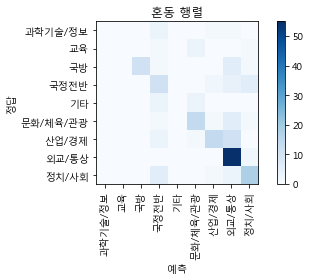

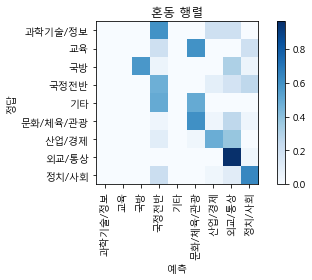

In [12]:
import sys
import ujson
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

FEATURE_POSES = ["NC", "NQ"]
MA_KEY = "body_ma"
LABEL_KEY = "field"
EXCEL_LABEL = "환경"


def read_documents_with_labels(input_file_name):
    documents = []
    labels = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)
            label = json_obj[LABEL_KEY]
            
            if label == EXCL_LABEL:
                continue
                
            labels.append(label)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue

                    morphs.append(morph_lex)

            document = " ".join(morphs)
            documents.append(document)

    # scikit의 다양한 기능을 이용하기 위해서
    # 파이썬 리스트를 numpy 모듈의 배열(array)로 바꾼다.
    documents = np.asarray(documents)
    labels = np.asarray(labels)
    
    return documents, labels


def build_doc_term_mats(train_documents, test_documents):
    vectorizer = CountVectorizer(tokenizer=str.split, binary=True)
    train_doc_term_mat = vectorizer.fit_transform(train_documents)
    test_doc_term_mat = vectorizer.transform(test_documents)

    return train_doc_term_mat, test_doc_term_mat


def build_classifier(train_doc_term_mat, train_labels):
    clf = MultinomialNB()
    clf.fit(train_doc_term_mat, train_labels)

    return clf


def get_conf_mats(clf, test_doc_term_mat, test_labels):
    pred_labels = clf.predict(test_doc_term_mat)
    conf_mat = confusion_matrix(test_labels, pred_labels)
    norm_conf_mat = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]
    
    print((test_labels, pred_labels))

    return conf_mat, norm_conf_mat


def set_font():
    if sys.platform.startswith("win"):
        matplotlib.rc("font", family="Malgun Gothic")
    elif sys.platform.startswith("darwin"):
        matplotlib.rc("font", family="AppleGothic")   
    

def draw_conf_mat(conf_mat, labels):
    plot_labels = sorted(set(labels))
    np.set_printoptions(precision=2)
    tick_marks = np.arange(len(plot_labels))

    fig = plt.figure()
    plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("혼동 행렬")
    plt.colorbar()
    plt.xticks(tick_marks, plot_labels, rotation=90)
    plt.yticks(tick_marks, plot_labels)
    fig.set_tight_layout(True)
    plt.ylabel("정답")
    plt.xlabel("예측")
    plt.show()


def main():
    input_file_name = "../data/speeches/nmh_speeches.ma.txt"
    documents, labels = read_documents_with_labels(input_file_name)
    train_documents, test_documents, train_labels, test_labels = \
            train_test_split(documents, labels)
    train_doc_term_mat, test_doc_term_mat = \
            build_doc_term_mats(train_documents, test_documents)
    clf = build_classifier(train_doc_term_mat, train_labels)
    conf_mat, norm_conf_mat = get_conf_mats(clf, test_doc_term_mat, test_labels)
    set_font()
    draw_conf_mat(conf_mat, labels)
    draw_conf_mat(norm_conf_mat, labels)


# 실행
main()

위의 스크립트는 앞선 분류 과제를 그대로 수행하면서 혼동 행렬을 생성하여 화면에 표시한다. 다만 그림을 한 번만 그리기 위해서 교차 검증은 하지 않았다.

`get_conf_mats()` 함수는 scikit 모듈의 `confusion_matrix()` 함수를 이용하여 2차원 배열 형식의 혼동 행렬을 만들어 돌려준다. 혼동 행렬은 앞서 설명한 바와 같이 실제 레이블과 분류기가 예측한 레이블을 비교하여 생성한다. 또한 정규화된 혼동 행렬도 생성하여 돌려준다. 정규화 혼동 행렬은 현재 주어진 과제와 같이 레이블의 쏠림이 심한 경우 레이블의 원분포가 아닌 비율에 의해 혼동의 정도를 측정한다.

`draw_conf_mat()` 함수는 일반 혼동 행렬과 정규화 혼동 행렬을 화면에 표시한다. 그래픽 표시에는 matplotlib이 사용된다.

# 분류기의 튜닝
분류기의 성능을 최적화하기 위해서는 분류 알고리즘에서 적용하는 파라미터들을 조정해야 한다. 각 파라미터들의 특성이 알려져 있는 경우에는 파라미터 조정에 지침이 될 수 있지만 그렇지 않은 경우에는 여러 번의 반복 실험을 거쳐야만 한다. 이 때에 사용할 수 있는 방법이 그리드 검색(grid search) 기법이다. 이 기법을 이용하면 복수 개의 파라미터의 조합 가운데 가장 최적화된 조합을 효율적으로 찾을 수 있다. 다음 소스를 보자.

In [13]:
import ujson
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

FEATURE_POSES = ["NC", "NQ"]
INPUT_FILE_NAME = "../data/speeches/nmh_speeches.ma.txt"
MA_KEY = "body_ma"
LABEL_KEY = "field"
EXCL_LABEL = "환경"


def read_documents_with_labels(input_file_name):
    documents = []
    labels = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)
            label = json_obj[LABEL_KEY]
            
            if label == EXCL_LABEL:
                continue
                
            labels.append(label)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue

                    morphs.append(morph_lex)

            document = " ".join(morphs)
            documents.append(document)

    # scikit의 다양한 기능을 이용하기 위해서
    # 파이썬 리스트를 numpy 모듈의 배열(array)로 바꾼다.
    documents = np.asarray(documents)
    labels = np.asarray(labels)
    
    return documents, labels


def build_pipeline():
    vectorizer = TfidfVectorizer(tokenizer=str.split)
    clf = MultinomialNB()
    pipeline = Pipeline([
        ('vect', vectorizer),
        ('clf', clf),
    ])
    
    return pipeline


def main():
    input_file_name = "../data/speeches/nmh_speeches.ma.txt"
    documents, labels = read_documents_with_labels(input_file_name)
    train_documents, test_documents, train_labels, test_labels = \
            train_test_split(documents, labels)
    pipeline = build_pipeline()

    parameters = {
        "vect__max_features": (5000, None),
        "vect__ngram_range": ((1, 1), (1, 2)),
        "vect__use_idf": (True, False),
        "vect__smooth_idf": (True, False),
        "vect__sublinear_tf": (True, False),
        "vect__norm": ("l1", "l2", None),
        "clf__alpha": (0, 0.1, 1.0),
    }

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, 
                               scoring="accuracy", cv=3)
    grid_search.fit(train_documents, train_labels)
    best_parameters = grid_search.best_estimator_.get_params()
    
    pred_labels = grid_search.predict(test_documents)

    print("Best score: {}".format(grid_search.best_score_))

    print("Best parameter set:")

    for param_name in parameters:
        print("\t{}: {}".format(param_name, best_parameters[param_name]))

    print("Accurary: {}".format(accuracy_score(test_labels, pred_labels)))


# 실행
main()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.9min finished


Best score: 0.6890034364261168
Best parameter set:
	vect__max_features: None
	vect__ngram_range: (1, 1)
	vect__use_idf: True
	vect__smooth_idf: False
	vect__sublinear_tf: True
	vect__norm: None
	clf__alpha: 1.0
Accurary: 0.7128205128205128


위 스크립트는 `Pipeline` 클래스를 이용하여 벡터라이저와 분류기를 하나로 묶어서 사용하며, `GridSearchCV` 클래스를 이용하여 미리 지정한 파라미터의 조합에 대한 그리드 검색을 수행하여 최적의 파라미터 조합을 출력한다. 위의 코드를 실행하면 다음과 같이 파라미터 탐색 과정과 결과가 표시된다.

```
...
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.2min finished
Best score: 0.7010309278350515
Best parameter set:
	vect__norm: None
	vect__max_features: None
	vect__use_idf: True
	vect__ngram_range: (1, 2)
	vect__smooth_idf: False
	vect__sublinear_tf: True
	clf__alpha: 1.0
Accurary: 0.6923076923076923
```

# 분류 과제의 평가
## 학습 곡선, 학습 시간, 그리고 기억 공간
분류 문제에서는 분류 알고리즘과 모델의 성능을 여러 면에서 평가할 수 있다. 그 가운데 중요한 요소 하나는 이른바 학습 곡선(learning curve)이다. 즉, 주어지는 학습 자료의 양에 따라 모델의 정확도가 향상, 유지, 혹은 감소되는 경향을 파악하는 것이다. 이는 학습 알고리즘마다 다른 특성을 가지고 있기 때문에 현실적으로 공급 가능한 학습 자료의 양에 따라 어떤 학습 알고리즘의 선택 기준이 될 수 있다.

이어서 살펴보아야 하는 것은 학습 시간과 기억 공간의 문제이다. 아무리 성능이 좋은 알고리즘이라고 하더라도 학습에 너무 오랜 시간이 소모된다면 실제 업무 적용에 제한이 있을 수 있다. 특히, 점진적 온라인 학습(incremental on-line learning)을 시도한다면 학습 시간은 매우 중요한 문제가 된다. 이와 함께 요구되는 기억 공간도 함께 살펴보아야 한다. 기계 학습은 대량의 복잡한 구조를 가진 객체를 주기억 장치에서 조작하도록 동작하는 것이 보통이다. 요구되는 기억 공간은 학습 자료의 양에 비례하여 증가할 것이므로 현실적인 고려를 통해 학습 자료의 양 역시 조절해야 할 것이다.

위에서 살펴본 요소들과 관련하여 최근에는 분산 처리에 의한 대규모 기계 학습 프레임워크들이 개발되고 있어 기존 하드웨어의 한계를 뛰어넘는 기계 학습 수행이 가능해지기 시작하였으므로 고려해 볼 만한다.

## 예측 성능의 평가
기계 학습의 관점에서 예측(prediction)이라 함은 주어진 자료들 간의 관계로부터 학습된 모델로 새로운 자료들 간의 관계를 추정하는 일을 말한다. 예를 들어, 2014년 신문 기사와 각 기사에 부여된 주제 분류 사이의 관계를 학습하여 2015년 신문 기사의 주제 분류를 추정하는 것이다. 이와 같은 예측의 성능을 계량적으로 평가하는 데에는 여러 가지 고려 사항이 있다.

가장 쉽게 생각해 볼 수 있는 예측 성능의 척도는 **정확도**(accuracy)이다. 시스템의 성능을 측정하는 이유는 시스템의 성능을 향상하기 위함인데 정확도만으로는 이 목적을 달성하기가 힘들다. 가능한 모든 답에 대하여 동등한 특성과 성능을 보이는 시스템은 현실적으로 존재하지 않기 때문에 시스템이 어떤 답을 더 잘 맞추는가를 살펴볼 필요가 있는 것이다. 이러한 배경에서 도입되는 지표가 정확률(precision)과 재현율(recall)이다.

## 정보 검색에서의 정확률과 재현율
정보 검색을 위해 100 개의 문서를 색인한 "미니" 검색 엔진이 있다고 가정해 보자. 여기에 "빅데이터"라는 키워드로 검색을 했는데, 검색 결과로 20 개의 문서가 나왔다. 20 개의 문서 중 16 개의 문서가 실제로 "빅데이터"와 관련된 문서였고, 전체 100개의 문서 중 "빅데이터"와 관련된 문서는 총 32개라고 하자. 이때 정확률과 재현율은 다음과 같이 정의된다.

* 정확률: 검색 결과로 가져온 문서 중 실제로 검색어와 관련된 문서의 비율
* 재현율: 문서 집합에 포함된 관련된 문서 중 검색된 문서의 비율

위의 정의를 식으로 나타내면 다음과 같다.

$$
  \text{precision} = \frac{|\{\text{relevant documents}\} \cap \{\text{retrieved documents}\}|}{|\{\text{retrieved documents}\}|}
$$

$$
  \text{recall} = \frac{|\{\text{relevant documents}\} \cap \{\text{retrieved documents}\}|}{|\{\text{relevant documents}\}|}
$$

위의 식의 따라 정확률과 재현율을 계산하면 다음과 같다.

$$
\text{정확률} = \frac{16}{20} = 0.8
$$

$$
\text{재현율} = \frac{16}{32} = 0.5
$$

재현율이란 관련된 문헌이 얼마나 많이 검색되었는가를, 즉 시스템이 관련 문헌을 검색해 내는 능력을 나타나며, 정확률은 검색된 문헌들이 얼마나 관련되었는가를 즉 시스템이 부적합 문헌을 검색해 내지 않는 능력을 나타내는 것이다.결국 재현율은 검색의 완전성을 측정하며 정확률은 검색의 정확성을 측정하는 것이라고 말할 수 있다. 그러므로 재현율을 높이려면 가능한 한 관련된 문헌을 많이 찾아야 하며 정확율을 높히려면 적합한 문헌만을 선택하고 비적합 문헌을 제외하기 위해 적합할 가능성이 높은 문헌만 추려내야 한다.

## 분류 과제에서의 정확도, 정확률, 재현율
분류 과제에서의 정확도, 정확률, 그리고 재현율에 대해서 알아보기 위해 먼저 다음과 같은 혼동 행렬을 상정한다.

|       |      Positive     |   Negative
| :----  | :--------: | :---------:
| predicted Positive | 1  | 2
| predicted Negative | 3  | 4

위의 표는 이진 분류 과제의 수행 결과에 대한 혼동 행렬을 표로 나타낸 것이다. 열로 주어진 것은 시험 자료의 실제 값이며 행으로 주어진 것은 이진 분류기의 예측 값이다. 주어진 과제가 10 개의 뉴스 기사로 이루어진 문서 집합에 대하여 진짜 뉴스(positive)인지 가짜 뉴스(negative)인지를 가려내는 과제라고 하자. 이 문서 집합에는 진짜 뉴스가 $1+3=4$ 건, 가짜 뉴스가 $2+4=6$ 건이 포함되어 있다. 이진 분류기는 이 문서 집합에 대하여 진짜 뉴스가 $1+2=3$ 건, 가짜 뉴스가 $3+4=7$ 건이 있다고 예측을 한 것이다.

위의 표의 각 칸은 그 성격 상 다음과 같이 나타낼 수 있다.

|       |      Positive     |   Negative
| :----  | :--------: | :---------:
| predicted Positive | True Positive  | False Positive
| predicted Negative | False Negative  | True Negative

* True Positive: 진짜 뉴스(Positive)라고 예측했는데 실제로도 맞음(True)
* True Negative: 가짜 뉴스(Negative)라고 예측했는데 실제로도 맞음(True)
* False Positive: 진짜 뉴스(Positive)라고 예측했는데 실제로는 틀림(False)
* False Negative: 가짜 뉴스(Negative)라고 예측했는데 실제로는 틀림(False)

이제 위의 표를 이용하여 정확도(Accuracy)를 구해보자. 정확도는 다음의 식으로 정의된다.

$$
\text{Accuracy} = \frac{TP+TN}{TP+TN+FN+FP}
$$

그러므로 정확도는 $\frac{1+4}{1+4+3+2}=0.5$이다. 총 문제 수 가운데 정답의 수를 구한 것이므로 매우 직관적이다. 그런데 분류기의 성능을 정확도에만 의존하여 측정하는 것은 적절치 않을 때가 있다. 실제 데이터에서 흔히 발생할 수 있는 부류의 불균형 분포 상황이 특히 문제가 된다.

|       |      Positive     |   Negative
| :----  | :--------: | :---------:
| predicted Positive | 100  | 150
| predicted Negative | 50  | 9700

위의 예는 실제 데이터에 Negative 부류가 훨씬 많은 경우이다. 여기서 분류기의 예측 정확도는 $\frac{100+9700}{100+9700+50+150}=0.98$로 매우 높다. 그런데 분류기를 조작하여 무조건 Negative로 예측하도록 하면 다음과 같은 상황이 된다.

|       |      Positive     |   Negative
| :----  | :--------: | :---------:
| predicted Positive | 0  | 0
| predicted Negative | 50  | 9700

이 경우 정확도를 구하면 $\frac{0+9700}{0+9700+50+0}=0.995$로 앞선 경우보다 높다. 공을 들여 만든 모델보다 무식한 예측이 훨씬 성능이 좋다. 이러한 상황을 정확도 역설(Accuracy Paradox)라고 부른다.

>위의 같이 분포가 큰 부류값으로 예측을 하는 모델을 영분류(Zero classification)라고 부른다.

정확도 역설을 피하기 위해서는 다음과 같이 정의되는 정확률과 재현율을 측정한다.

$$
\text{Precision} = \frac{TP}{TP+FP}
$$

$$
\text{Recall} = \frac{TP}{TP+FN}
$$

이어서 정확률과 재현율의 조화평균인 $\text{F1}$ 값을 다음과 같이 정의하여 두 값의 균형값을 측정한다.

$$
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

무식한 예측보다 정확도가 낮았던 실험 결과에서 위의 측정치들을 모두 구하면 다음과 같다.

$$
\text{Accuracy} = \frac{100+9700}{100+9700+50+150}=0.98
$$

$$
\text{Precision} = \frac{100}{100+150}=0.4
$$

$$
\text{Recall} = \frac{100}{100+50}=0.667
$$

$$
\text{F1} = \frac{2 \times 0.4 \times 0.667}{0.4 + 0.667}=0.50
$$

계산 결과를 살펴보면 정확도는 높지만 다른 값들은 그리 높지 않다. 즉, 이 모델을 주어진 시험 문서 집합에 대하여 우연히 높은 정확도를 보였을 가능성이 높은 것이다. 그렇다면 아주 이상적인 상황에서의 이들 측정치는 어떻게 나오지는지 살펴보자.

|       |      Positive     |   Negative
| :----  | :--------: | :---------:
| predicted Positive | 99  | 2
| predicted Negative | 1  | 98

$$
\text{Accuracy} = \frac{99+98}{99+98+1+2}=0.985
$$

$$
\text{Precision} = \frac{99}{99+2}=0.9802
$$

$$
\text{Recall} = \frac{99}{99+1}=0.99
$$

$$
\text{F1} = \frac{2 \times 0.9802 \times 0.99}{0.9802 + 0.99}=0.9851
$$

모든 측정치가 높게 나온다. 한편 분류기의 성능을 높히려면 예측 값이 실제 값과 일치하지 않는 오류를 줄여야 한다. 오류는 위의 표에서 볼 수 있듯이 두 군데에서 발생한다.

* False Postivie: 제1 유형 오류, 실제로는 Negative인데 Positive로 예측한 경우
* False Negative: 제2 유형 오류, 실제로는 Positive인데 Negative로 예측한 경우

위 두 유형의 오류는 분류 과제의 성격에 따라 경중이 다르다. 예를 들어, 중고차 성능 판별 과제에서는 제1 유형, 즉 좋은 자동차라 예측하고 구매하였지만 실제로는 좋지 않은 자동차였을 경우가 더 치명적이다. 좋은 중고차를 나쁜 차로 예측하여 사지 않는 것은 손해볼 것이 없지만 나쁜 중고차를 좋은 차로 잘못 예측하여 사는 것은 손해가 크다. 분류 과제가 암환자 진단이라면 제2 유형, 즉 실제로는 암 환자를 건강하다고 판별하여 환자의 생명이 위협을 받을 수 있는 경우가 훨씬 더 치명적이다.

## 정확률, 재현율 측정 실험
위의 교차 검증 코드에 그리드 검색을 통해 얻어진 인자들을 반영하여 정확률과 재현율을 측정해 보자.

In [14]:
import ujson
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np


FEATURE_POSES = ["NC", "NQ"]
MA_KEY = "body_ma"
LABEL_KEY = "field"
EXCL_LABEL = "환경"
NUM_FOLDS = 10


def read_documents_with_labels(input_file_name):
    documents = []
    labels = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)
            label = json_obj[LABEL_KEY]
            
            if label == EXCL_LABEL:
                continue
                
            labels.append(label)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue

                    morphs.append(morph_lex)

            document = " ".join(morphs)
            documents.append(document)

    # scikit의 다양한 기능을 이용하기 위해서
    # 파이썬 리스트를 numpy 모듈의 배열(array)로 바꾼다.
    documents = np.asarray(documents)
    labels = np.asarray(labels)
    
    return documents, labels


def build_doc_term_mats(train_documents, test_documents):
    vectorizer = TfidfVectorizer(tokenizer=str.split, norm=None,
                                 use_idf=True, ngram_range=(1,2),
                                 smooth_idf=False, sublinear_tf=True)
    train_doc_term_mat = vectorizer.fit_transform(train_documents)
    test_doc_term_mat = vectorizer.transform(test_documents)

    return train_doc_term_mat, test_doc_term_mat


def build_classifier(train_doc_term_mat, train_labels):
    clf = MultinomialNB(alpha=1.0)
    clf.fit(train_doc_term_mat, train_labels)

    return clf


def test_classifier(clf, test_doc_term_mat, test_labels):
    pred_labels = clf.predict(test_doc_term_mat)
    accuracy = accuracy_score(test_labels, pred_labels)
    precision = precision_score(test_labels, pred_labels, average="macro")
    recall = recall_score(test_labels, pred_labels, average="macro")
    f1 = f1_score(test_labels, pred_labels, average="macro")

    return accuracy, precision, recall, f1


def main():
    input_file_name = "../data/speeches/nmh_speeches.ma.txt"
    documents, labels = read_documents_with_labels(input_file_name)
    cross_val_set = KFold(n=len(documents), n_folds=NUM_FOLDS, shuffle=True)
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for train, test in cross_val_set:
        train_documents = documents[train]
        train_labels = labels[train]
        test_documents = documents[test]
        test_labels = labels[test]

        train_doc_term_mat, test_doc_term_mat = \
                build_doc_term_mats(train_documents, test_documents)
        clf = build_classifier(train_doc_term_mat, train_labels)
        accuracy, precision, recall, f1 = \
                test_classifier(clf, test_doc_term_mat, test_labels)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    print("Avg Accuracy: {}, Std Dev: {}".format(np.mean(accuracies), 
                                                 np.std(accuracies)))
    print("Avg Preision: {}, Std Dev: {}".format(np.mean(precisions), 
                                                 np.std(precision)))
    print("Avg Recall: {}, Std Dev: {}".format(np.mean(recalls), 
                                               np.std(recalls)))
    print("Avg F1: {}, Std Dev: {}".format(np.mean(f1s), 
                                           np.std(f1s)))

    
# 실행
main()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Avg Accuracy: 0.7102730602730604, Std Dev: 0.06577643604534415
Avg Preision: 0.6430304870063753, Std Dev: 0.0
Avg Recall: 0.5760914328878839, Std Dev: 0.08119842918204451
Avg F1: 0.5768405766470271, Std Dev: 0.08300179991152526
